In [32]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.decomposition import PCA

In [3]:
coarse_factors = [32]
Directory = f"data"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz

In [4]:
model_number = 11

train_times = pd.read_csv(Directory+f'/test_train_times/times_train_{model_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
test_times = pd.read_csv(Directory+f'/test_train_times/times_test_{model_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
print(train_times)
print(test_times)

[49  5 33 54 26  8 17 46 20 60 57 13 31  7 11  3 62  9 56  1 44 32 52 35
 22 58 24 47 55 42 23  2 14 27 43 10 21 34 59 45 51  4 41 29 25 18 53 19
 28]
[12 36 37 50 40 16 48 38  6 39 15 61 30]


In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_train, output_train, input_test, output_test = utils.make_train_test_ds(coarse_factors, len_in, train_times, test_times, Directory)
ins = [input_train.numpy(), input_test.numpy()]
outs = [output_train.numpy(), output_test.numpy()]

reduced_len = 100

for j in range(len(ins)):
    input = ins[j]
    input = input.reshape(-1,len(variables)-1,nz)
    for i in range(len(variables)-1):
        input[:,i] -= np.mean(input[:,i])
        input[:,i] /= np.std(input[:,i])
    input = input.reshape(-1,(len(variables)-1)*nz)
    ins[j] = input

for i in range(len(outs)):
    output = outs[i]
    output -= np.mean(output)
    output /= np.std(output)
    outs[i] = output

In [41]:
pca = PCA()

X_train_pca = pca.fit_transform(ins[0])
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

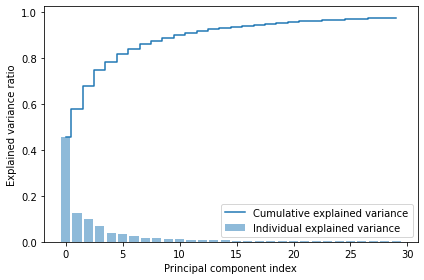

In [46]:
c_max = 30
plt.bar(range(0,len(exp_var_pca[:c_max])), exp_var_pca[:c_max], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues[:c_max])), cum_sum_eigenvalues[:c_max], where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()